In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import shutil
import string
import tensorflow as tf
import re

from tensorflow.keras import layers
from tensorflow.keras import losses

In [4]:
df = pd.read_csv('reviews_labeled.csv')


In [3]:
# print(df)


                                                      text  label
0        if you decide to eat here, just be aware it is...      1
1        family diner. had the buffet. eclectic assortm...      1
2        wow!  yummy, different,  delicious.   our favo...      1
3        cute interior and owner (?) gave us tour of up...      1
4        i am a long term frequent customer of this est...      0
...                                                    ...    ...
4724466  don't misinterpret my 5-star review....i don't...      1
4724467  it is very rare for a restaurant to be this go...      1
4724468  good, maybe very good.  i went for lunch, so t...      1
4724469  for when i'm feeling like ignoring my calorie-...      1
4724470  located in the 'walking district' in nashville...      1

[4724471 rows x 2 columns]


In [5]:
neg_text = df.loc[df.label == 0, ['text', 'label']]
pos_text = df.loc[df.label == 1, ['text', 'label']]
df = 0
# neg_text.head()


In [7]:
tn = neg_text.sample(n=600000, axis=0)
tp = pos_text.sample(n=600000, axis=0)
equal_base = pd.concat([tn,tp])
tn, tp = 0, 0
tensor_dict_from_sample = tf.data.Dataset.from_tensor_slices((dict(equal_base)))


In [9]:
# print(equal_base.shape)
# print(equal_base)


(1200000, 2)
                                                      text  label
894909   staff can be rude. i was trying to get informa...      0
2382543  after a 20 minute wait for 3 bubble teas, i wa...      0
691795   the hostesses told us it'd be a 15 minute wait...      0
1804414  so no picture today. i got the wings. they suc...      0
2999722  the service was very good, the beer was excell...      0
...                                                    ...    ...
1868144  great food and awesome events. the pig roast e...      1
2528353  we have been to a number of mexican restaurant...      1
997003   this is better than an average diner, with a h...      1
1450637  great location and fun atmosphere!  we were th...      1
3868288  first experience with indian food and i have t...      1

[1200000 rows x 2 columns]


Data sampled to guarantee proper distribution of negative and positive reviews.
Next step: Create tensors and data subsets directly in tensors to be used in the model.

In [9]:
print(tensor_dict_from_sample)
sample_data = tensor_dict_from_sample.shuffle(1200000)
text_array = []
label_array = []
for row in sample_data.take(-1):
  text_array.append(row['text'].numpy())
  label_array.append(row['label'].numpy())

# print(text_array[:2])
# print(label_array[:2]) 

<TensorSliceDataset element_spec={'text': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [10]:
base_text_tensor = tf.convert_to_tensor(text_array)
base_label_tensor = tf.convert_to_tensor(label_array)

# print(base_text_tensor)

In [11]:
# neg_tensor_sample = neg_tensor_sample.batch(32)
# print(neg_tensor_dict)
train_text, test_text, val_text = tf.split(base_text_tensor, [600000, 480000, 120000])
train_label, test_label, val_label = tf.split(base_label_tensor, [600000, 480000, 120000])
# print(test_label[352348])
# print(test_text[352348])
train_data = tf.data.Dataset.from_tensor_slices((train_text, train_label)).batch(32)
test_data = tf.data.Dataset.from_tensor_slices((test_text, test_label)).batch(32)
val_data = tf.data.Dataset.from_tensor_slices((val_text, val_label)).batch(32)


In [142]:
# val_set = []

# for row in val_label.take(-1):
#     val_set.append(row)

In [61]:
# for row in val_label.take(1):
#     print(row)
# for lrow in val_text.take(1):
#     print(lrow)

In [12]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [13]:
max_features = 20000
sequence_length = 500

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [14]:
# Make a text-only dataset (without labels), then call adapt
vectorize_layer.adapt(train_text)

In [15]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [16]:
# retrieve a batch (of 32 reviews and labels) from the dataset
# text_batch = next(iter(train_text))
# label_batch = next(iter(train_label))
# first_review, first_label = text_batch[0], label_batch[0]
# print("Review", first_review)
# print("Label", first_label)
# print("Vectorized review", vectorize_text(first_review, first_label))
text_batch, label_batch = next(iter(train_data))
first_review, first_label = text_batch[0], label_batch[0]
# print("Review", first_review)
# print("Label", train_data.class_names[first_label])
# print("Vectorized review", vectorize_text(first_review, first_label))

In [98]:
# print("1287 ---> ",vectorize_layer.get_vocabulary(include_special_tokens=False)[1287])
# print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
# print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

In [17]:
train_ds = train_data.map(vectorize_text)
val_ds = val_data.map(vectorize_text)
test_ds = test_data.map(vectorize_text)


In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
embedding_dim = 16

In [20]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          320016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
__________________________________________________

In [21]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [156]:
epochs = 1
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

18750/18750 [==============================] - 379s 20ms/step - loss: 0.2807 - binary_accuracy: 0.9040 - val_loss: 0.2288 - val_binary_accuracy: 0.9186


In [157]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

15000/15000 [==============================] - 190s 13ms/step - loss: 0.2325 - binary_accuracy: 0.9174
Loss:  0.23252184689044952
Accuracy:  0.9174166917800903


In [159]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

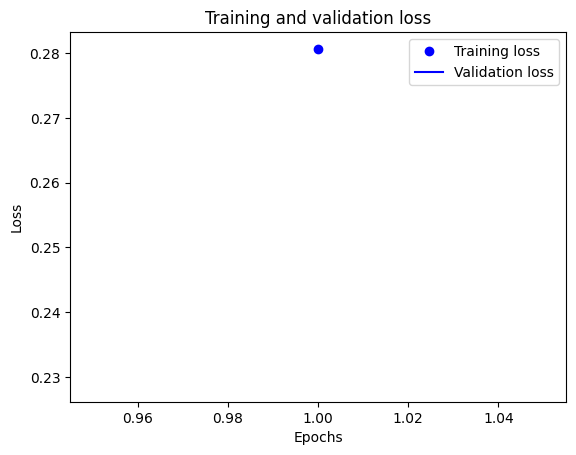

In [160]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

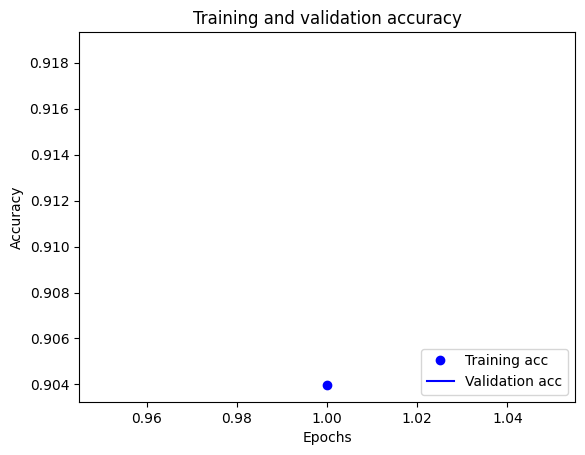

In [161]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.show()

In [163]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(test_data)
print(accuracy)

15000/15000 [==============================] - 227s 15ms/step - loss: 0.2325 - accuracy: 0.9174
0.9174166917800903


In [164]:
examples = [
  "The burger was great!",
  "The pizza was okay.",
  "The soup was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 166ms/step


array([[0.6901936 ],
       [0.45034015],
       [0.23840262]], dtype=float32)